In [34]:
%load_ext autoreload
%autoreload 2

#  https://mapreader.readthedocs.io/en/latest/Install.html
import os, sys
sys.path.append('../scripts/')
import mapreader
import cartopy
from torchvision import models
from torch import nn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load .tif

In [2]:
# load map tif paths
from mapreader import loader
my_files = loader("../content/tifs/masked/*.tif")
my_files.add_geo_info() # if pre georeferenced may need to set: target_crs 
print(my_files)

  0%|          | 0/13 [00:00<?, ?it/s]

#images: 13

#parents: 13
SK1070_combined.tif
SK1468_combined.tif
SK1469_combined.tif
SK1474_combined.tif
SK1476_combined.tif
SK1567_combined.tif
SK1570_combined.tif
SK1668_combined.tif
SK1678_combined.tif
SK1767_combined.tif
SK1768_combined.tif
...

#patches: 0



In [3]:
my_files.parents["SK1070_combined.tif"]["shape"]

(1492, 1491, 3)

In [8]:
# not needed now 3 bands
parent_list = my_files.list_parents()
for parent in parent_list:
    my_files.parents[parent]["shape"] = (*my_files.parents[parent]["shape"], 1)

### Patchify

In [4]:
# set directory & patch size (pixels unless -- method="meters" )
my_files.patchify_all(path_save="../content/tifs/patches/", patch_size=25)
my_files.save_patches_as_geotiffs()

[INFO] Saving patches in directory named "../content/tifs/patches/".


  0%|          | 0/13 [00:00<?, ?it/s]

..\content\tifs\masked\SK1070_combined.tif
..\content\tifs\masked\SK1468_combined.tif
..\content\tifs\masked\SK1469_combined.tif
..\content\tifs\masked\SK1474_combined.tif
..\content\tifs\masked\SK1476_combined.tif
..\content\tifs\masked\SK1567_combined.tif
..\content\tifs\masked\SK1570_combined.tif
..\content\tifs\masked\SK1668_combined.tif
..\content\tifs\masked\SK1678_combined.tif
..\content\tifs\masked\SK1767_combined.tif
..\content\tifs\masked\SK1768_combined.tif
..\content\tifs\masked\SK1867_combined.tif
..\content\tifs\masked\SK1868_combined.tif


  0%|          | 0/46800 [00:00<?, ?it/s]

In [5]:
parent_list = my_files.list_parents()
patch_list = my_files.list_patches()

print(parent_list)
print(patch_list[0:5])  # too many to print them all!

['SK1070_combined.tif', 'SK1468_combined.tif', 'SK1469_combined.tif', 'SK1474_combined.tif', 'SK1476_combined.tif', 'SK1567_combined.tif', 'SK1570_combined.tif', 'SK1668_combined.tif', 'SK1678_combined.tif', 'SK1767_combined.tif', 'SK1768_combined.tif', 'SK1867_combined.tif', 'SK1868_combined.tif']
['patch-0-0-25-25-#SK1070_combined.tif#.png', 'patch-0-25-25-50-#SK1070_combined.tif#.png', 'patch-0-50-25-75-#SK1070_combined.tif#.png', 'patch-0-75-25-100-#SK1070_combined.tif#.png', 'patch-0-100-25-125-#SK1070_combined.tif#.png']


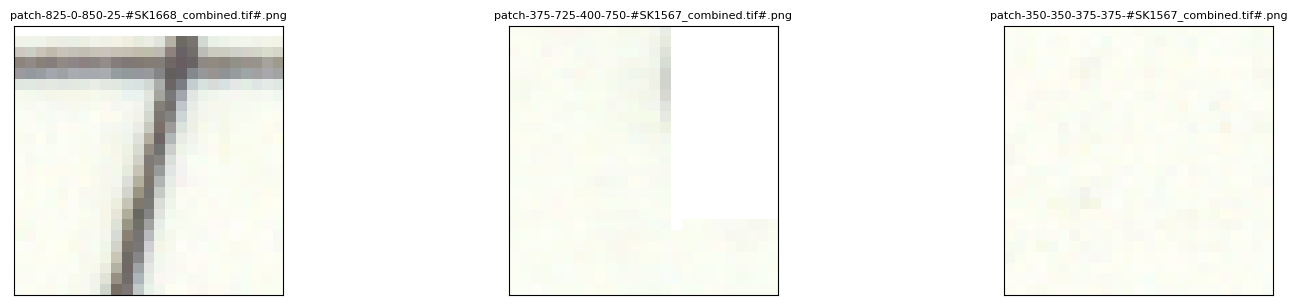

In [6]:
my_files.show_sample(num_samples=3, tree_level="patch")

  0%|          | 0/1 [00:00<?, ?it/s]

[<Figure size 1000x1000 with 1 Axes>]

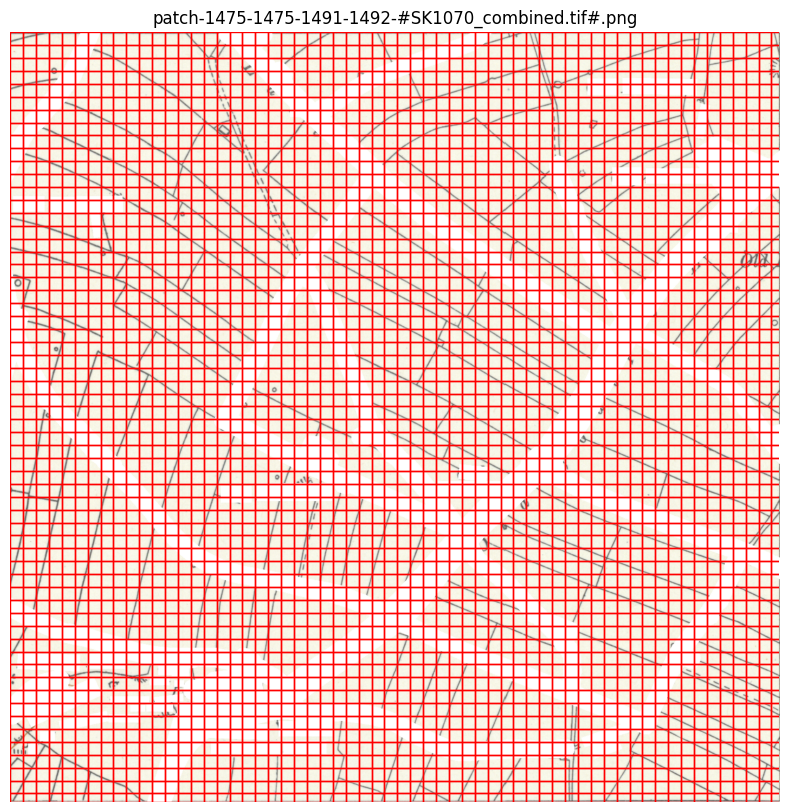

In [7]:
# show patches
parent_list = my_files.list_parents()
my_files.show_parent(parent_list[0])

In [9]:
my_files.calc_pixel_stats()
parent_df, patch_df = my_files.convert_images()
parent_df["url"]="fake_url"

  0%|          | 0/13 [00:00<?, ?it/s]

### Annotate

In [18]:
from mapreader import Annotator

annotator = Annotator(
    patch_df=patch_df,
    parent_df=parent_df,
    task_name="walls",
    labels=["no_wall", "wall"],
    annotations_dir = "../content/annotations_1950/",
    username="DavidA",
    show_context=True,
)

annotator.annotate(resize_to=300, show_context=True, surrounding=3) #to resize up the tiny patch, you might also want show_context=False as its confusing

Output(layout=Layout(align_items='center', display='flex', flex_flow='column'))

In [19]:
# save annotations
annotator.annotations_file

'../content/annotations_1950/walls_#DavidA#-caa624db443ea99d131b03bcff56f254.csv'

### Train

In [21]:
# Load and check annotations 

import pandas as pd

df = pd.read_csv(annotator.annotations_file, index_col=0)
df["image_id"]=df.index

from mapreader import AnnotationsLoader

annotated_images = AnnotationsLoader()
annotated_images.load(annotations=df)

[INFO] Number of annotations:   1000

[INFO] Number of instances of each label (from column "label"):
    - no_wall:  633
    - wall:  367



In [22]:
# view the data
annotated_images.annotations

,image_path,label,image_id,label_index
image_id,,,,
patch-0-0-25-25-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall,patch-0-0-25-25-#SK1070_combined.tif#.png,0
patch-0-100-25-125-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall,patch-0-100-25-125-#SK1070_combined.tif#.png,0
patch-0-1000-25-1025-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall,patch-0-1000-25-1025-#SK1070_combined.tif#.png,0
patch-0-1025-25-1050-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall,patch-0-1025-25-1050-#SK1070_combined.tif#.png,0
patch-0-1050-25-1075-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall,patch-0-1050-25-1075-#SK1070_combined.tif#.png,0
...,...,...,...,...
patch-75-875-100-900-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall,patch-75-875-100-900-#SK1070_combined.tif#.png,0
patch-75-900-100-925-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall,patch-75-900-100-925-#SK1070_combined.tif#.png,0
patch-75-925-100-950-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall,patch-75-925-100-950-#SK1070_combined.tif#.png,0


In [36]:
# label map
annotated_images.labels_map

{0: 'wall', 1: 'no_wall'}

In [29]:
# look at no walls
annotated_images.show_image_labels("no_wall")

AttributeError: 'AnnotationsLoader' object has no attribute 'show_image_labels'

[INFO] Type "exit", "end" or "stop" to exit.
[INFO] Showing 0-24 out of 1000.


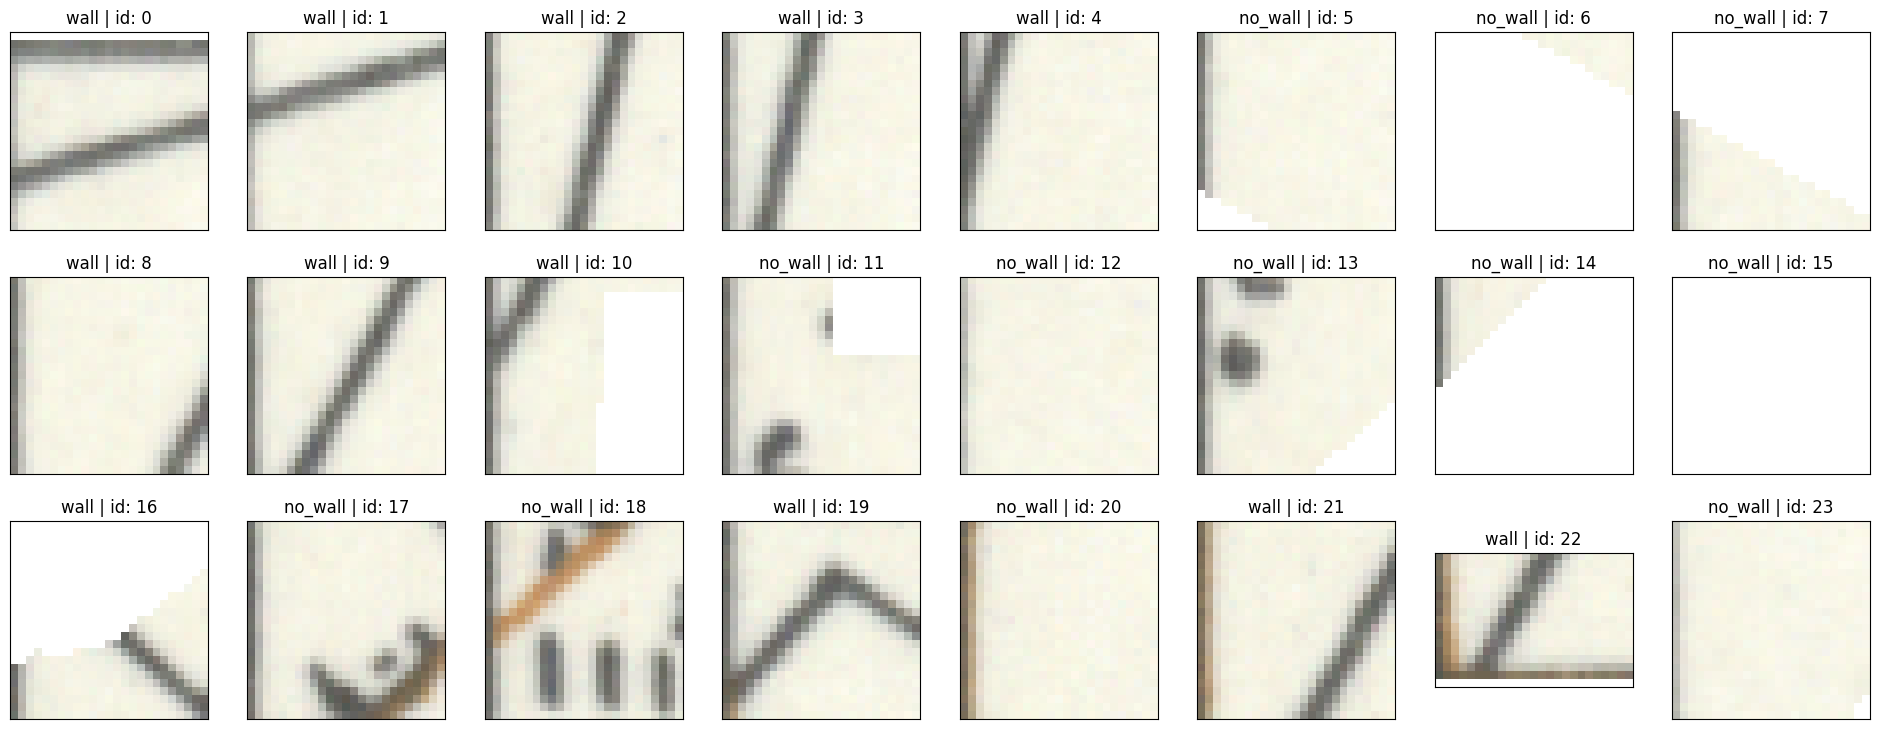

[INFO] IDs of current patches: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
[INFO] Exited.


In [30]:
# walls
annotated_images.review_labels()

In [32]:
# Prepare datasets and dataloaders
dataloaders = annotated_images.create_dataloaders()

[INFO] Using default sampler.


### Train

In [37]:
from mapreader import ClassifierContainer
my_classifier = ClassifierContainer("resnet18", annotated_images.labels_map, dataloaders)

[INFO] Device is set to cpu
[INFO] Initializing model.
[INFO] Loaded "train" with 700 items.
[INFO] Loaded "val" with 150 items.
[INFO] Loaded "test" with 150 items.


In [38]:
# loss function
my_classifier.add_criterion("cross-entropy")

[INFO] Using "CrossEntropyLoss()" as criterion.


In [39]:
# optimizer 
my_classifier.initialize_optimizer()

In [40]:
# scheduler
my_classifier.initialize_scheduler()

In [41]:
# train with default 25 epochs
my_classifier.train()

[INFO] Each step will pass: ['train', 'val'].
2024-01-05 13:37:12 PC05258 [INFO] train    -- 1/25 --     16/700 (  2.3% ) -- Loss: 0.426
2024-01-05 13:37:15 PC05258 [INFO] train    -- 1/25 --     96/700 ( 13.7% ) -- Loss: 1.562
2024-01-05 13:37:19 PC05258 [INFO] train    -- 1/25 --    176/700 ( 25.1% ) -- Loss: 0.815
2024-01-05 13:37:22 PC05258 [INFO] train    -- 1/25 --    256/700 ( 36.6% ) -- Loss: 0.904
2024-01-05 13:37:27 PC05258 [INFO] train    -- 1/25 --    336/700 ( 48.0% ) -- Loss: 0.325
2024-01-05 13:37:34 PC05258 [INFO] train    -- 1/25 --    416/700 ( 59.4% ) -- Loss: 0.612
2024-01-05 13:37:40 PC05258 [INFO] train    -- 1/25 --    496/700 ( 70.9% ) -- Loss: 0.273
2024-01-05 13:37:46 PC05258 [INFO] train    -- 1/25 --    576/700 ( 82.3% ) -- Loss: 0.421
2024-01-05 13:37:52 PC05258 [INFO] train    -- 1/25 --    656/700 ( 93.7% ) -- Loss: 0.273
2024-01-05 13:37:55 PC05258 [INFO] train    -- 1/25 -- Loss: 0.446; F_macro: 82.24; R_macro: 80.65
2024-01-05 13:37:56 PC05258 [INFO] v

### Plot metrics

In [42]:
list(my_classifier.metrics.keys())

['epoch_loss_train',
 'epoch_prec_micro_train',
 'epoch_recall_micro_train',
 'epoch_fscore_micro_train',
 'epoch_supp_micro_train',
 'epoch_rocauc_micro_train',
 'epoch_prec_macro_train',
 'epoch_recall_macro_train',
 'epoch_fscore_macro_train',
 'epoch_supp_macro_train',
 'epoch_rocauc_macro_train',
 'epoch_prec_weighted_train',
 'epoch_recall_weighted_train',
 'epoch_fscore_weighted_train',
 'epoch_supp_weighted_train',
 'epoch_rocauc_weighted_train',
 'epoch_prec_0_train',
 'epoch_recall_0_train',
 'epoch_fscore_0_train',
 'epoch_supp_0_train',
 'epoch_prec_1_train',
 'epoch_recall_1_train',
 'epoch_fscore_1_train',
 'epoch_supp_1_train',
 'epoch_loss_val',
 'epoch_prec_micro_val',
 'epoch_recall_micro_val',
 'epoch_fscore_micro_val',
 'epoch_supp_micro_val',
 'epoch_rocauc_micro_val',
 'epoch_prec_macro_val',
 'epoch_recall_macro_val',
 'epoch_fscore_macro_val',
 'epoch_supp_macro_val',
 'epoch_rocauc_macro_val',
 'epoch_prec_weighted_val',
 'epoch_recall_weighted_val',
 'epoch_fs

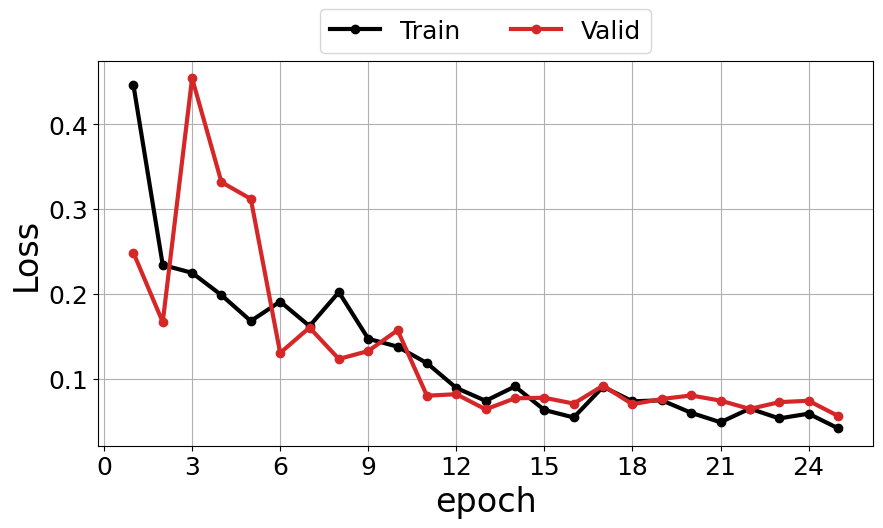

In [43]:
# loss per epoch of training and validation
my_classifier.plot_metric(
    y_axis=["epoch_loss_train", "epoch_loss_val"],
    y_label="Loss",
    legends=["Train", "Valid"],
)

### Testing

In [44]:
my_classifier.inference(set_name="test")

[INFO] Each step will pass: ['test'].
2024-01-05 14:02:35 PC05258 [INFO] test     -- 26/26 --     16/150 ( 10.7% ) -- 
2024-01-05 14:02:36 PC05258 [INFO] test     -- 26/26 --     96/150 ( 64.0% ) -- 
[INFO] Total time: 0m 2s


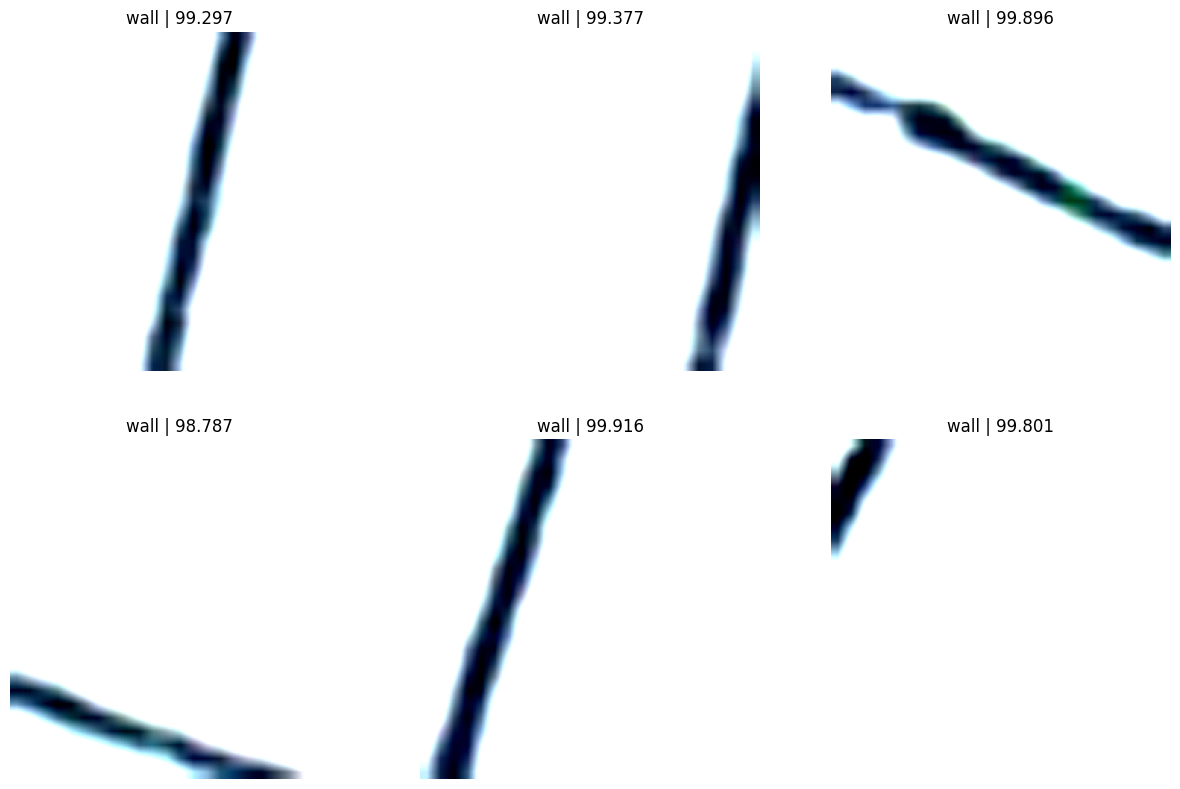

In [45]:
# prediction sample
my_classifier.show_inference_sample_results(label="wall")

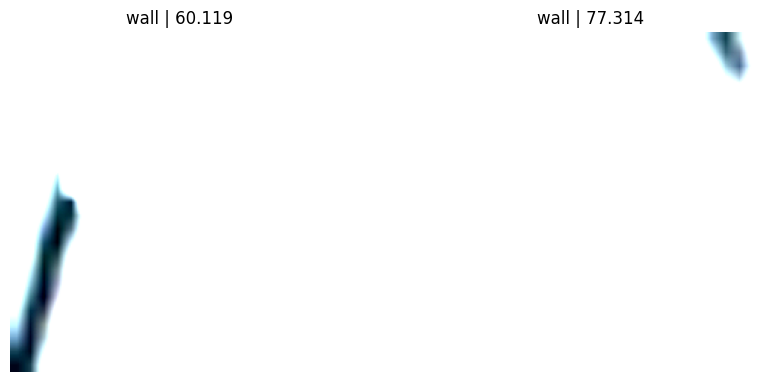

In [50]:
# prediction sample
my_classifier.show_inference_sample_results(label="wall", max_conf=80)

In [53]:
my_classifier.calculate_add_metrics(
    y_true=my_classifier.orig_label,
    y_pred=my_classifier.pred_label,
    y_score=my_classifier.pred_conf,
    phase="test",
)

In [55]:
my_classifier.metrics["epoch_rocauc_macro_test"]

[0.7846889952153111]

### Save

In [56]:
my_classifier.save("test_1.pkl")

### Model Inference

In [57]:
from mapreader import PatchDataset

In [72]:
infer = PatchDataset("../content/annotations_1950/walls_#DavidA#-caa624db443ea99d131b03bcff56f254.csv", delimiter=",", transform="test")

[INFO] Reading "../content/annotations_1950/walls_#DavidA#-caa624db443ea99d131b03bcff56f254.csv".


In [74]:
# add this dataset to ClassifierContainer()
my_classifier.load_dataset(infer, set_name="infer")

In [75]:
my_classifier.inference(set_name="infer")

[INFO] Each step will pass: ['infer'].
2024-01-05 14:56:08 PC05258 [INFO] infer    -- 26/26 --    16/1000 (  1.6% ) -- 
2024-01-05 14:56:09 PC05258 [INFO] infer    -- 26/26 --    96/1000 (  9.6% ) -- 
2024-01-05 14:56:10 PC05258 [INFO] infer    -- 26/26 --   176/1000 ( 17.6% ) -- 
2024-01-05 14:56:11 PC05258 [INFO] infer    -- 26/26 --   256/1000 ( 25.6% ) -- 
2024-01-05 14:56:12 PC05258 [INFO] infer    -- 26/26 --   336/1000 ( 33.6% ) -- 
2024-01-05 14:56:13 PC05258 [INFO] infer    -- 26/26 --   416/1000 ( 41.6% ) -- 
2024-01-05 14:56:15 PC05258 [INFO] infer    -- 26/26 --   496/1000 ( 49.6% ) -- 
2024-01-05 14:56:16 PC05258 [INFO] infer    -- 26/26 --   576/1000 ( 57.6% ) -- 
2024-01-05 14:56:17 PC05258 [INFO] infer    -- 26/26 --   656/1000 ( 65.6% ) -- 
2024-01-05 14:56:18 PC05258 [INFO] infer    -- 26/26 --   736/1000 ( 73.6% ) -- 
2024-01-05 14:56:19 PC05258 [INFO] infer    -- 26/26 --   816/1000 ( 81.6% ) -- 
2024-01-05 14:56:20 PC05258 [INFO] infer    -- 26/26 --   896/1000 ( 8

### Add predictions to metadata and save

In [76]:
import numpy as np

infer.patch_df['predicted_label'] = my_classifier.pred_label
infer.patch_df['pred'] = my_classifier.pred_label_indices
infer.patch_df['conf'] = np.array(my_classifier.pred_conf).max(axis=1)

In [73]:
infer.patch_df

,image_id,image_path,label
0,patch-0-0-25-25-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall
1,patch-0-100-25-125-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall
2,patch-0-1000-25-1025-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall
3,patch-0-1025-25-1050-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall
4,patch-0-1050-25-1075-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall
...,...,...,...
995,patch-75-875-100-900-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall
996,patch-75-900-100-925-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall
997,patch-75-925-100-950-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall
998,patch-75-950-100-975-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall


0it [00:00, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/46800 [00:00<?, ?it/s]

[INFO] Add shape, tree level: parent


  0%|          | 0/1 [00:00<?, ?it/s]

[<Figure size 1000x1000 with 2 Axes>]

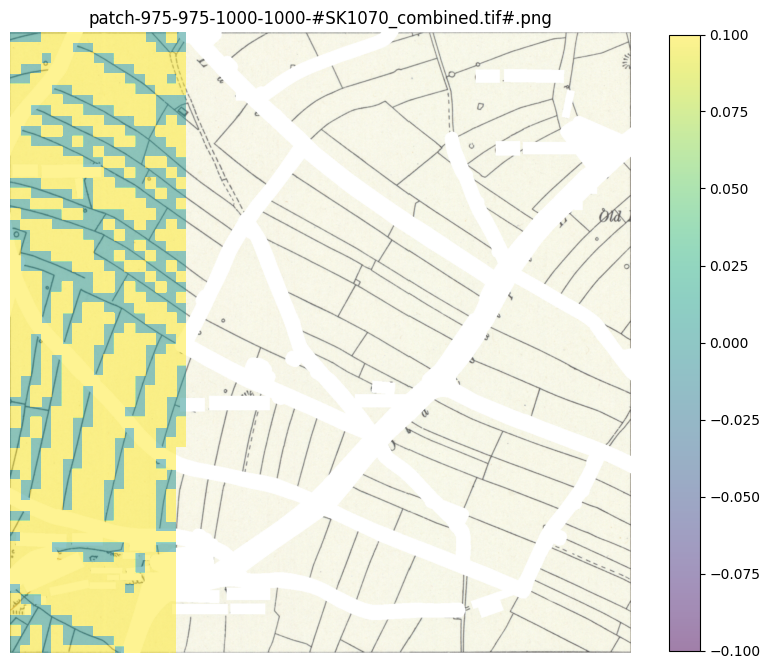

In [88]:
from mapreader import load_patches

my_maps = load_patches(patch_paths = "../content/tifs/patches/*png", parent_paths="../content/tifs/masked/*.tif")

infer_df = infer.patch_df
my_maps.add_metadata(infer_df, tree_level='patch', ignore_mismatch=True) # add dataframe as metadata
my_maps.add_shape()

parent_list = my_maps.list_parents()
my_maps.show_parent(parent_list[0], column_to_plot="pred", vmin=0, vmax=1, alpha=0.5, patch_border=False)

### Full data test

In [103]:
patch_df.head()

,parent_id,image_path,shape,pixel_bounds,coordinates,crs,polygon,geotiff_path,mean_pixel_R,mean_pixel_G,mean_pixel_B,std_pixel_R,std_pixel_G,std_pixel_B
image_id,,,,,,,,,,,,,,
patch-0-0-25-25-#SK1070_combined.tif#.png,SK1070_combined.tif,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,"(25, 25, 3)","(0, 0, 25, 25)","(-1.8516676236042906, 53.226945732114494, -1.8...",EPSG:4326,POLYGON ((-1.8514158144882014 53.2269457321144...,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,0.832157,0.830482,0.789289,0.176909,0.173345,0.161569
patch-0-25-25-50-#SK1070_combined.tif#.png,SK1070_combined.tif,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,"(25, 25, 3)","(0, 25, 25, 50)","(-1.8516676236042906, 53.227096169172846, -1.8...",EPSG:4326,POLYGON ((-1.8514158144882014 53.2270961691728...,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,0.961293,0.953682,0.895755,0.039232,0.041379,0.037379
patch-0-50-25-75-#SK1070_combined.tif#.png,SK1070_combined.tif,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,"(25, 25, 3)","(0, 50, 25, 75)","(-1.8516676236042906, 53.22724660623119, -1.85...",EPSG:4326,POLYGON ((-1.8514158144882014 53.2272466062311...,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,0.961092,0.955765,0.898704,0.040898,0.039841,0.035361
patch-0-75-25-100-#SK1070_combined.tif#.png,SK1070_combined.tif,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,"(25, 25, 3)","(0, 75, 25, 100)","(-1.8516676236042906, 53.22739704328954, -1.85...",EPSG:4326,POLYGON ((-1.8514158144882014 53.2273970432895...,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,0.959128,0.953180,0.895216,0.041304,0.040486,0.035594
patch-0-100-25-125-#SK1070_combined.tif#.png,SK1070_combined.tif,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,"(25, 25, 3)","(0, 100, 25, 125)","(-1.8516676236042906, 53.227547480347894, -1.8...",EPSG:4326,POLYGON ((-1.8514158144882014 53.2275474803478...,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,0.882359,0.880345,0.830720,0.150095,0.147566,0.134672


In [102]:
predictions = PatchDataset(patch_df, transform="test")

In [99]:
# add this dataset to ClassifierContainer()
my_classifier.load_dataset(patch_df, set_name="predictions")

In [100]:
my_classifier.inference(set_name="predictions")

[INFO] Each step will pass: ['predictions'].


KeyError: 0

In [ ]:
import numpy as np

predictions.patch_df['predicted_label'] = my_classifier.pred_label
predictions.patch_df['pred'] = my_classifier.pred_label_indices
predictions.patch_df['conf'] = np.array(my_classifier.pred_conf).max(axis=1)

In [ ]:
infer.patch_df

In [ ]:
from mapreader import load_patches

my_maps = load_patches(patch_paths = "../content/tifs/patches/*png", parent_paths="../content/tifs/masked/*.tif")

infer_df = infer.patch_df
my_maps.add_metadata(infer_df, tree_level='patch', ignore_mismatch=True) # add dataframe as metadata
my_maps.add_shape()

parent_list = my_maps.list_parents()
my_maps.show_parent(parent_list[0], column_to_plot="pred", vmin=0, vmax=1, alpha=0.5, patch_border=False)